In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [ ]:
class LogisticEndpoint(keras.layers.Layer):
    def __init__(self, name=None):
        super(LogisticEndpoint, self).__init__(name=name)
        self.loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
        self.accuracy_fn = keras.metrics.BinaryAccuracy()

    def call(self, targets, logits, sample_weights=None):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        loss = self.loss_fn(targets, logits, sample_weights)
        self.add_loss(loss)

        # Log accuracy as a metric and add it
        # to the layer using `self.add_metric()`.
        acc = self.accuracy_fn(targets, logits, sample_weights)
        self.add_metric(acc, name="accuracy")

        # Return the inference-time prediction tensor (for `.predict()`).
        return tf.nn.softmax(logits)

In [ ]:
layer = LogisticEndpoint()

In [ ]:
targets = tf.ones((2, 2))
logits = tf.ones((2, 2))
y = layer(targets, logits)

In [ ]:
print("layer.metrics:", layer.metrics)
print("current accuracy value:", float(layer.metrics[0].result()))
inputs = keras.Input(shape=(3,), name="inputs")
targets = keras.Input(shape=(10,), name="targets")
logits = keras.layers.Dense(10)(inputs)
predictions = LogisticEndpoint(name="predictions")(logits, targets)

layer.metrics: [<keras.metrics.BinaryAccuracy object at 0x7f4e9fb83550>]
current accuracy value: 1.0


In [ ]:
model = keras.Model(inputs=[inputs, targets], outputs=predictions)
model.compile(optimizer="adam")

In [ ]:
data = {
    "inputs": np.random.random((3, 3)),
    "targets": np.random.random((3, 10)),
}
model.fit(data)

1/1 [==============================] - 1s 678ms/step - loss: 0.9517 - binary_accuracy: 0.0000e+00


In [ ]:
#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers

import tensorflow as tf
from tensorflow import keras
import numpy as np

#from keras.models import Model
#from keras.layers import Input
#from keras.layers import Conv2D
#from keras.layers import MaxPooling2D
#from keras.layers.merge import concatenate
#from keras.utils import plot_model

In [ ]:
#inception naive version

def inception_module(x, f1, f2, f3):
	# 1x1 conv
	conv1 =  keras.layers.Conv2D(f1, (1,1), padding='same', activation='relu')(x)
	# 3x3 conv
	conv3 = keras.layers.Conv2D(f2, (3,3), padding='same', activation='relu')(x)
	# 5x5 conv
	conv5 = keras.layers.Conv2D(f3, (5,5), padding='same', activation='relu')(x)
	# 3x3 max pooling
	pool = keras.layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
	# concatenate filters
	out = keras.layers.merge.concatenate([conv1, conv3, conv5, pool])
	return out

In [ ]:
img_input = keras.Input(shape=(299, 299, 3))
classes=2
WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.5/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
WEIGHTS_PATH = 'inception_v3_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
channel_axis=3

In [ ]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Drishti Vgg16/prepro/clahee/train',
                                                 target_size = (224, 224),
                                                 batch_size = 3,
                                                 class_mode = 'categorical')

Found 49 images belonging to 2 classes.


In [ ]:
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Drishti Vgg16/prepro/clahee/test',
                                            target_size = (224, 224),
                                            batch_size = 3,
                                            class_mode = 'categorical')

Found 31 images belonging to 2 classes.


In [ ]:
def conv2d_bn(x,filters,num_row,num_col,padding='same',strides=(1, 1)):
   
    x = keras.layers.Conv2D(filters, (num_row, num_col),strides=strides,padding=padding)(x)
    x = keras.layers.BatchNormalization(axis=3, scale=False)(x)
    x = keras.layers.Activation('relu')(x)
    return x

In [ ]:
def inc_block_a(x):    
    branch1x1 = conv2d_bn(x, 64, 1, 1)  # 64 filters of 1*1

    branch5x5 = conv2d_bn(x, 48, 1, 1)  #48 filters of 1*1
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = keras.layers.AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 32, 1, 1)
    x = keras.layers.concatenate([branch1x1, branch5x5, branch3x3dbl, branch_pool], axis=channel_axis)
    return x

In [ ]:
def reduction_block_a(x):  
    branch3x3 = conv2d_bn(x, 384, 3, 3, strides=(2, 2), padding='valid')

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3, strides=(2, 2), padding='valid')

    branch_pool = keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = keras.layers.concatenate([branch3x3, branch3x3dbl, branch_pool],axis=channel_axis)
    return x

In [ ]:
# 17 x 17 x 768
def inc_block_b(x):
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 128, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 128, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 128, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = keras.layers.AveragePooling2D((3, 3), strides=(1, 1),padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = keras.layers.concatenate([branch1x1, branch7x7, branch7x7dbl, branch_pool], axis=channel_axis)
    return x

In [ ]:
# mixed 8: 8 x 8 x 1280
def reduction_block_b(x): 
    branch3x3 = conv2d_bn(x, 192, 1, 1)
    branch3x3 = conv2d_bn(branch3x3, 320, 3, 3,strides=(2, 2), padding='valid')

    branch7x7x3 = conv2d_bn(x, 192, 1, 1)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 1, 7)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 7, 1)
    branch7x7x3 = conv2d_bn( branch7x7x3, 192, 3, 3, strides=(2, 2), padding='valid')

    branch_pool = keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = keras.layers.concatenate([branch3x3, branch7x7x3, branch_pool], axis=channel_axis)
    return x

In [ ]:
def inc_block_c(x):        
        branch1x1 = conv2d_bn(x, 320, 1, 1)

        branch3x3 = conv2d_bn(x, 384, 1, 1)
        branch3x3_1 = conv2d_bn(branch3x3, 384, 1, 3)
        branch3x3_2 = conv2d_bn(branch3x3, 384, 3, 1)
        branch3x3 = keras.layers.concatenate([branch3x3_1, branch3x3_2],axis=channel_axis)

        branch3x3dbl = conv2d_bn(x, 448, 1, 1)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 384, 3, 3)
        branch3x3dbl_1 = conv2d_bn(branch3x3dbl, 384, 1, 3)
        branch3x3dbl_2 = conv2d_bn(branch3x3dbl, 384, 3, 1)
        branch3x3dbl = keras.layers.concatenate([branch3x3dbl_1, branch3x3dbl_2], axis=channel_axis)

        branch_pool = keras.layers.AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = keras.layers.concatenate( [branch1x1, branch3x3, branch3x3dbl, branch_pool],axis=channel_axis)
        return x

In [ ]:
img_input = keras.Input(shape=(299, 299, 3))  #shape=(None, 299, 299, 3)

In [ ]:
# input image size: 299 x 299 x 3
x = conv2d_bn(img_input, 32, 3, 3, strides=(2, 2), padding='valid') # 149 x 149 x 32
x = conv2d_bn(x, 32, 3, 3, padding='valid')  # 147 x 147 x 32
x = conv2d_bn(x, 64, 3, 3) # 147 x 147 x 64

x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(x)   # 73  x 73 x 64
x = conv2d_bn(x, 80, 1, 1, padding='valid') # 73 x 73 x 80
x = conv2d_bn(x, 192, 3, 3, padding='valid')  # 71 x 71 x 192
x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(x)  # 35 x 35 x 192


x=inc_block_a(x) #35, 35, 256
x=inc_block_a(x) #35, 35, 256
x=inc_block_a(x) #35, 35, 256

x=reduction_block_a(x) #17, 17, 736

x=inc_block_b(x) #17, 17, 768
x=inc_block_b(x) #17, 17, 768
x=inc_block_b(x) #17, 17, 768
x=inc_block_b(x) #17, 17, 768

x=reduction_block_b(x) #shape=(None, 8, 8, 1280)

x=inc_block_c(x) # shape=(None, 8, 8, 2048) 
x=inc_block_c(x) # shape=(None, 8, 8, 2048) 

x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x) # shape=(None, 2048)

x = keras.layers.Dense(classes, activation='softmax', name='predictions')(x) #shape=(None, 1000) 



# Create model.
inputs = img_input
model =  keras.Model(inputs, x, name='inception_v3')
model.summary()



Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=30,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/30
17/17 [==============================] - 52s 2s/step - loss: 2.1350 - accuracy: 0.4898 - val_loss: 0.7408 - val_accuracy: 0.2581
Epoch 2/30
17/17 [==============================] - 30s 2s/step - loss: 0.8676 - accuracy: 0.4898 - val_loss: 1.0753 - val_accuracy: 0.2581
Epoch 3/30
17/17 [==============================] - 32s 2s/step - loss: 0.8038 - accuracy: 0.6327 - val_loss: 0.6387 - val_accuracy: 0.7419
Epoch 4/30
17/17 [==============================] - 32s 2s/step - loss: 0.6769 - accuracy: 0.6735 - val_loss: 0.6416 - val_accuracy: 0.7419
Epoch 5/30
17/17 [==============================] - 30s 2s/step - loss: 0.6915 - accuracy: 0.6735 - val_loss: 0.8038 - val_accuracy: 0.2581
Epoch 6/30
17/17 [==============================] - 30s 2s/step - loss: 0.7530 - accuracy: 0.6531 - val_loss: 0.8784 - val_accuracy: 0.2581
Epoch 7/30
17/17 [==============================] - 30s 2s/step - loss: 0.6021 - accuracy: 0.7347 - val_loss: 0.7126 - val_accuracy: 0.3226
Epoch 8/30
17/17 [==

In [ ]:
import matplotlib.pyplot as plt

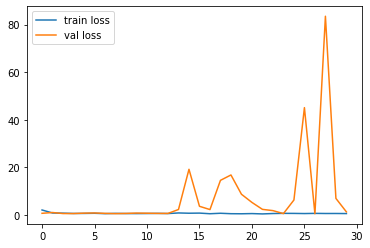

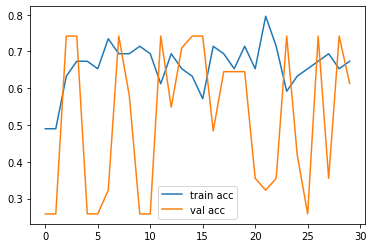

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

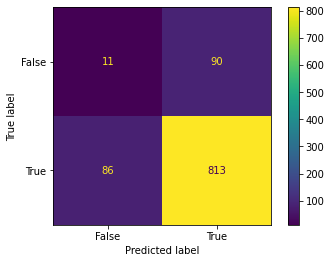

In [ ]:
import matplotlib.pyplot as plt 
import numpy 
from sklearn import metrics 
 
actual = numpy.random.binomial(1,.9,size = 1000) 
predicted = numpy.random.binomial(1,.9,size = 1000) 
 
confusion_matrix = metrics.confusion_matrix(actual, predicted) 
 
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True]) 
 
cm_display.plot() 
plt.show()